In [ ]:
#we can do model versioning data tracking and hyperparameter tuning experimentation tracking visualizatn etc with wandb

In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.6/289.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.4 MB/s eta 0:00:00


In [15]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
import io
from sklearn.metrics import confusion_matrix

In [16]:
import wandb
from wandb.keras import WandbCallback

In [22]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
wandb.init(project="wandb_learning", entity="daniyaljmi777")
#for a project different runs we can create and this init for creating runs
#and for stopping that run we do wandb.finish()

wandb: Currently logged in as: khandanu777 (daniyaljmi777). Use `wandb login --relogin` to force relogin


In [23]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 3,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 256,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [24]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

lenet_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    tf.keras.layers.Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    tf.keras.layers.Dropout(rate = DROPOUT_RATE ),

    tf.keras.layers.Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = DROPOUT_RATE),

    tf.keras.layers.Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 254, 254, 6)       168       
                                                                 
 batch_normalization_4 (Bat  (None, 254, 254, 6)       24        
 chNormalization)                                                
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 6)       0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 127, 127, 6)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 16)      880       
                                                                 
 batch_normalization_5 (Bat  (None, 125, 125, 16)     

In [ ]:
(ds_train), ds_info = tfds. load (
    "cats_vs_dogs", #it is name that is in catelog of link above
    split=["train"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,

)

ds_train=ds_train[0]

def normalize_image(image, label):
  image=tf.image.resize(image, (256,256))
  return tf.cast(image, tf.float32)/255.0, label

AUTOTUNE=tf.data.experimental.AUTOTUNE #tf allow us to give this to set automatically
BATCH_SIZE=1

ds_train=ds_train.map(normalize_image, num_parallel_calls=AUTOTUNE) # in normalize function these is no sequence so
#process can be done paralelly
ds_train= ds_train.cache() #it keep next data in memory so it will be fast
ds_train=ds_train.shuffle(1000) #we can give 1000 so it will see 1000 datat points but
#it depends on records in a file so take from that
ds_train=ds_train.batch(BATCH_SIZE)
ds_train=ds_train.prefetch(AUTOTUNE) #it keeps 64 examples ready when running on gpu the current one



ds_train=ds_train.take(100)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.1.incompleteCUXMDP/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [ ]:
metrics = [tf.keras.metrics.TruePositives(name='tp'),tf.keras.metrics.FalsePositives(name='fp'), tf.keras.metrics.TrueNegatives(name='tn'), tf.keras.metrics.FalseNegatives(name='fn'),
            tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
FACTOR = 1
LABELS = ['dogs', 'cats']


lenet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = tf.keras.losses.BinaryCrossentropy(),
      metrics = metrics)

### Experimentation Tracking

In [ ]:
#the metrices we define in this will be logged in wandb site beacuse we used this keras callback

In [ ]:
history = lenet_model.fit(
    ds_train,
    #validation_data = val_dataset,
    epochs = 1,#CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[WandbCallback(save_model=(True))]
    )

# WandbCallback(
#     monitor="val_loss", verbose=0, mode="auto", save_weights_only=(False),
#     log_weights=(False), log_gradients=(False), save_model=(True),
#     training_data=None, validation_data=None, labels=None, predictions=36,
#     generator=None, input_type=None, output_type=None, log_evaluation=(False),
#     validation_steps=None, class_colors=None, log_batch_frequency=None,
#     log_best_prefix="best_", save_graph=(True), validation_indexes=None,
#     validation_row_processor=None, prediction_row_processor=None,
#     infer_missing_processors=(True), log_evaluation_frequency=0,
#     compute_flops=(False), **kwargs
# )

#we can give validatn trining data so can do some visualization

1000/1000 [==============================] - 131s 129ms/step - loss: 0.6936 - tp: 326.0000 - fp: 316.0000 - tn: 190.0000 - fn: 168.0000 - accuracy: 0.5160 - precision: 0.5078 - recall: 0.6599 - auc: 0.4870


In [ ]:
val_im=[]
val_lab=[]
for im, label in ds_train:
  val_im.append(im.numpy().reshape(256,256,3))
  val_lab.append(label.numpy())
val_im=np.array(val_im)
val_lab=np.array(val_lab)

In [ ]:
history = lenet_model.fit(
    ds_train,
    #validation_data = val_dataset,
    epochs=CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[WandbCallback(validation_data=[val_im, val_lab],
                             save_weights_only=(True),
                             labels=LABELS,
                             data_type='image'
                             )]
    )

1000/1000 [==============================] - 127s 126ms/step - loss: 0.6938 - tp: 141.0000 - fp: 150.0000 - tn: 346.0000 - fn: 363.0000 - accuracy: 0.4870 - precision: 0.4845 - recall: 0.2798 - auc: 0.4785


In [ ]:
wandb.finish()

In [ ]:
wandb.init(project="wandb_learning", entity="daniyaljmi777")

In [ ]:
#plotting confusion matrix in wandb, it is easier than tensorboard, and we can get all these visualization code
#from wandb github and site

In [ ]:
#we create custom callback that inherit keras callback
class LogConfMatrix(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []

    for im, label in ds_train:
      predicted.append(lenet_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.array([i[0] for i in labels])

    #in wandb site we get this code for ploting different plots

    cm = wandb.plot.confusion_matrix( #this line is for giving this plot to wandb
        y_true=lab,
        preds=pred,
        class_names=LABELS)

    wandb.log({"conf_mat": cm})

In [ ]:
#we put softmax and dense 2 in last layer so that confusion matrix can be plotted properly as according
#to pred and lebs created

lenet_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    tf.keras.layers.Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    tf.keras.layers.Dropout(rate = DROPOUT_RATE ),

    tf.keras.layers.Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = DROPOUT_RATE),

    tf.keras.layers.Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(REGULARIZATION_RATE)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(2, activation = "softmax"),

])

LABELS = ['cats', 'dogs']


lenet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics = 'accuracy')


In [ ]:
history = lenet_model.fit(
    ds_train,
    #validation_data = val_dataset,
    epochs=CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[LogConfMatrix(),
               ]
    )

1000/1000 [==============================] - 160s 156ms/step - loss: 0.6926 - accuracy: 0.5130


In [ ]:
wandb.finish()

In [ ]:
# logging roc curve

In [ ]:
wandb.init(project="wandb_learning", entity="daniyaljmi777")

In [ ]:
label.numpy()[0]

0

In [ ]:
#it is giving error with creating pred and labels as having int values
#i think for this we need [0 1] for mat pred
class LogRocCurve(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []
    pred=[]
    lab=[]

    for im, label in ds_train:
      predicted.append(lenet_model(im))
      labels.append(label.numpy())

    #pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.array([i[0] for i in labels])

    for i in range(len(predicted)):
      if(predicted[i][0] < 0.5):
        pred.append([1,0])
      else:
        pred.append([0,1])

    pred = np.array(pred)

    # for i in range(len(labels)):
    #   if(labels[i][0] ==0):
    #     lab.append([1,0])
    #   else:
    #     lab.append([0,1])

    # lab = np.array(lab) lab need to be 0,1 while pred shoul be like[1 0], [0 1]

    wandb.log({"ROC Curve" : wandb.plot.roc_curve(
        y_true = lab,
        y_probas = pred,
        labels = ['dogs', 'cats'],
    )})

    #we can log many things like confusn matrix n all and then plot like this wandb.log({'loss':logs['loss']})

    wandb.log({'loss':logs['loss']})

In [ ]:
lenet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
      loss = tf.keras.losses.BinaryCrossentropy(),
      metrics = metrics)

In [ ]:
history = lenet_model.fit(
    ds_train,
    #validation_data = val_dataset,
    epochs=CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[LogRocCurve(),
               ]
    )

100/100 [==============================] - 21s 168ms/step - loss: 0.6977 - tp: 100.0000 - fp: 99.0000 - tn: 49.0000 - fn: 52.0000 - accuracy: 0.4967 - precision: 0.5025 - recall: 0.6579 - auc: 0.4550


In [ ]:
wandb.finish()

loss,▁█
loss,0.69772


In [ ]:
#we can log any type of image we want to log

In [ ]:
wandb.init(project="wandb_learning", entity="daniyaljmi777")

In [ ]:
class LogImagesCallbackWandB(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    predicted = []
    labels = []
    pred=[]
    lab=[]

    for im, label in ds_train:
      predicted.append(lenet_model(im))
      labels.append(label.numpy())

    pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
    lab = np.array([i[0] for i in labels])


    cm = confusion_matrix(lab, pred)

    plt.figure(figsize=(8,8))

    sns.heatmap(cm, annot=True,)
    plt.title('Confusion matrix - {}'.format(0.5))
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.axis('off')

    buffer = io.BytesIO()
    plt.savefig(buffer, format = 'png')

    image_array = tf.image.decode_png(buffer.getvalue(), channels=3)

    images = wandb.Image(image_array, caption="Confusion Matrix for epoch: {}".format(epoch))

    wandb.log(
        {"Confusion Matrix": images})


Epoch 1/3
100/100 [==============================] - 22s 201ms/step - loss: 0.6933 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 53.0000 - fn: 47.0000 - accuracy: 0.5300 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.3222
Epoch 2/3
100/100 [==============================] - 17s 152ms/step - loss: 0.6919 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 54.0000 - fn: 46.0000 - accuracy: 0.5400 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4336
Epoch 3/3
100/100 [==============================] - 17s 153ms/step - loss: 0.6939 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 51.0000 - fn: 49.0000 - accuracy: 0.5100 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4544


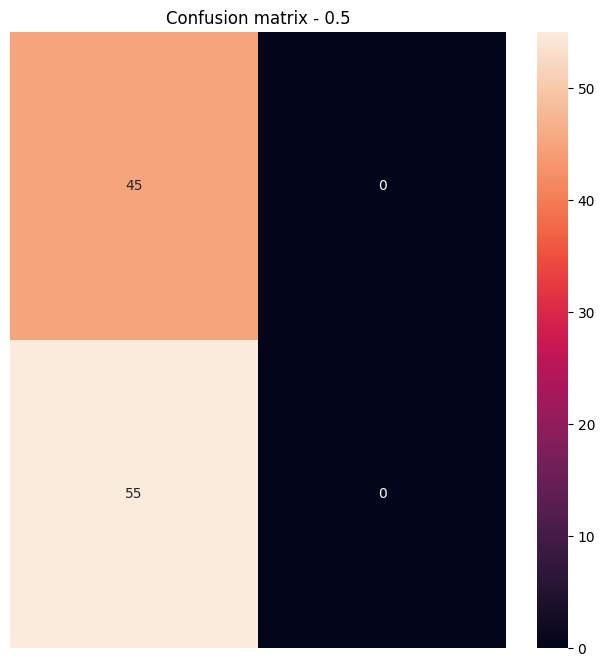

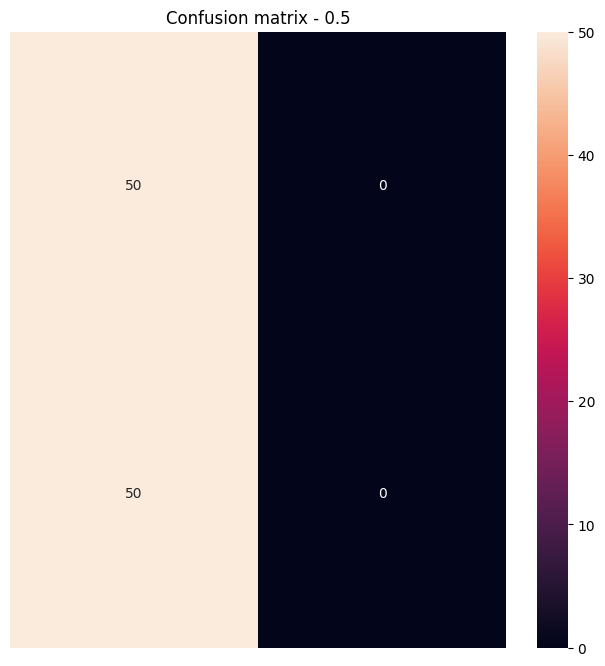

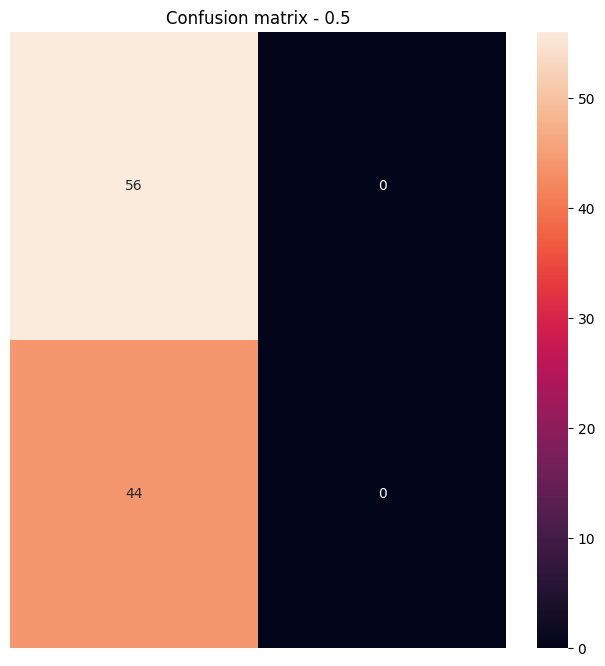

In [ ]:
history = lenet_model.fit(
    ds_train,
    #validation_data = val_dataset,
    epochs=CONFIGURATION['N_EPOCHS'],
    verbose = 1,
    callbacks=[LogImagesCallbackWandB(),
               ]
    )

In [ ]:
wandb.finish()

In [ ]:
#we can also use logs that is created by tensorboard for wandb

#do this for init
###wandb.tensorboard.patch(root_logdir="./logs") #define log dir of tensorboard, without this line also working
#wandb.init(project="Malaria-Detection", entity="neuralearn", sync_tensorboard=True)

### Hyperparameter tuning

In [ ]:
sweep_config = {
  "name" : "wandb-learning-sweep",
  "method" : "random", #here we define random search, we can also define grid search for all possibilities
  "metric": {
      "name" : "accuracy",
      "goal" : "maximize",
  },
  "parameters" : {

    "IM_SIZE": {
        "value" : 256,
    },

    "N_EPOCHS": {
        "value" : 1,
    },

    "KERNEL_SIZE": {
        "value" : 3,
    },

    "N_STRIDES": {
        "value" : 1,
    },

    "POOL_SIZE": {
        "value" : 224,
    },

    "N_FILTERS" : {
        "value" : 6,
    },

    "N_DENSE_1" : {
      "values" : [16, 32, 64, 128]
    },

    "N_DENSE_2" : {
      "values" : [16, 32, 64, 128]
    },

    "DROPOUT_RATE":{
      "min": 0.1,
      "max": 0.4
    },

    "REGULARIZATION_RATE" :{
      "distribution": "uniform",
      "min": 0.001,
      "max": 0.1
    },

    "LEARNING_RATE" :{
      "distribution": "uniform",
      "min": 1e-4,
      "max": 1e-2
    }
  },
}

sweep_id = wandb.sweep(sweep_config)

Create sweep with ID: g7usa2k5
Sweep URL: https://wandb.ai/daniyaljmi777/uncategorized/sweeps/g7usa2k5


In [ ]:
IM_SIZE = 256
def model_tune(config):
  lenet_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (256, 256, 3)),

    tf.keras.layers.Conv2D(filters = 6 , kernel_size = 3, strides = 1 , padding='valid',
          activation = 'relu',kernel_regularizer = tf.keras.regularizers.L2(config['REGULARIZATION_RATE'])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size = 1, strides= config['N_STRIDES']*2),
    tf.keras.layers.Dropout(rate = config['DROPOUT_RATE'] ),

    tf.keras.layers.Conv2D(filters = 16, kernel_size = 3, strides = 1, padding='valid',
          activation = 'relu', kernel_regularizer = tf.keras.regularizers.L2(config['REGULARIZATION_RATE'])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D (pool_size = 1, strides= 2),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense( config['N_DENSE_1'], activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(config['REGULARIZATION_RATE'])),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(rate = DROPOUT_RATE),

    tf.keras.layers.Dense( config['N_DENSE_2'], activation = "relu", kernel_regularizer = tf.keras.regularizers.L2(config['REGULARIZATION_RATE'])),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(1, activation = "sigmoid"),

  ])


  return lenet_model

In [ ]:
#for hyperparameter tuning we use val data
val_im=[]
val_lab=[]
for im, label in ds_train:
  val_im.append(im.numpy().reshape(256,256,3))
  val_lab.append(label.numpy())
val_im=np.array(val_im)
val_lab=np.array(val_lab)

In [ ]:
def train():
    with wandb.init(project="wandb_learning", entity="daniyaljmi777") as run:
        config = wandb.config
        model = model_tune(config) #we need to pass the wandb.config and name that is defined in this should be same
        #as sweep config names for hyperparameters
        model.compile(
              optimizer= tf.keras.optimizers.Adam(
                  learning_rate = config['LEARNING_RATE']),
              loss='binary_crossentropy',
              metrics=['accuracy'],
              )
        model.fit(x=val_im, y=val_lab, epochs=2, callbacks = [WandbCallback()])
        #wandb.log({"loss": loss, "epoch": epoch})

count = 5 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: 1ms4yg7m with config:
wandb: 	DROPOUT_RATE: 0.14026990995485877
wandb: 	IM_SIZE: 256
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.0026636028768958994
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 128
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.09561524127533907
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/2
4/4 [==============================] - 6s 861ms/step - loss: 8.4652 - accuracy: 0.5900
Epoch 2/2
4/4 [==============================] - 4s 832ms/step - loss: 10.6470 - accuracy: 0.7000


accuracy,▁█
epoch,▁█
loss,▁█
accuracy,0.7
epoch,1
loss,10.64699


wandb: Agent Starting Run: wcun91hk with config:
wandb: 	DROPOUT_RATE: 0.16232125753296736
wandb: 	IM_SIZE: 256
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.005415848176329157
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 64
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.0051927719172691475
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/2
4/4 [==============================] - 8s 1s/step - loss: 1.4013 - accuracy: 0.5600
Epoch 2/2
4/4 [==============================] - 6s 1s/step - loss: 2.2150 - accuracy: 0.6900


accuracy,▁█
epoch,▁█
loss,▁█
accuracy,0.69
epoch,1
loss,2.215


wandb: Agent Starting Run: kmm317a3 with config:
wandb: 	DROPOUT_RATE: 0.18693905844826356
wandb: 	IM_SIZE: 256
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.008395746272440904
wandb: 	N_DENSE_1: 128
wandb: 	N_DENSE_2: 64
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.014204441406403426
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/2
4/4 [==============================] - 6s 987ms/step - loss: 16.2020 - accuracy: 0.5600
Epoch 2/2
4/4 [==============================] - 6s 1s/step - loss: 54.3082 - accuracy: 0.5500


accuracy,█▁
epoch,▁█
loss,▁█
accuracy,0.55
epoch,1
loss,54.30815


wandb: Agent Starting Run: ppen8tbb with config:
wandb: 	DROPOUT_RATE: 0.1825453807296807
wandb: 	IM_SIZE: 256
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.008034760975285772
wandb: 	N_DENSE_1: 16
wandb: 	N_DENSE_2: 32
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.07732181958581488
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/2
4/4 [==============================] - 6s 869ms/step - loss: 11.6462 - accuracy: 0.5100
Epoch 2/2
4/4 [==============================] - 6s 2s/step - loss: 27.6225 - accuracy: 0.7200


accuracy,▁█
epoch,▁█
loss,▁█
accuracy,0.72
epoch,1
loss,27.62249


wandb: Agent Starting Run: yw6jifcq with config:
wandb: 	DROPOUT_RATE: 0.17801810158302486
wandb: 	IM_SIZE: 256
wandb: 	KERNEL_SIZE: 3
wandb: 	LEARNING_RATE: 0.003166568781210073
wandb: 	N_DENSE_1: 64
wandb: 	N_DENSE_2: 64
wandb: 	N_EPOCHS: 1
wandb: 	N_FILTERS: 6
wandb: 	N_STRIDES: 1
wandb: 	POOL_SIZE: 224
wandb: 	REGULARIZATION_RATE: 0.03435669719632702
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Epoch 1/2
4/4 [==============================] - 8s 1s/step - loss: 9.8181 - accuracy: 0.5000
Epoch 2/2
4/4 [==============================] - 4s 882ms/step - loss: 15.9955 - accuracy: 0.8900


accuracy,▁█
epoch,▁█
loss,▁█
accuracy,0.89
epoch,1
loss,15.99546


In [ ]:
#correlation in wandb site tell that if red so higher the bar that means the more small will give large acc
#and more green bar size then more acc when that param is more

### Data Versioning

In [ ]:
# dataloader -> original data -> cleaned dataset ->split into train, test, val -> preprocess train, val, test -> augment train data

#for every datasetabove created we should have versions for that as every time changes made
#info that is mainained for data versioning are artifacts
#artifacts are connected with runs, as runs create different versions if changes made or happen

In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files = True, split=['train'])


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [ ]:
dataset

In [ ]:
for data in dataset[0]:
  print(data[0].shape)
  break

In [ ]:
data[1].numpy()

In [ ]:
!mkdir /content/dataset
k = 0
for data in dataset[0]:

  with open('/content/dataset/malaria_dataset_'+str(k) + '.npz', mode = 'wb') as file:
    np.savez(file,data[0], data[1])
  k += 1

  if(k%1000 == 0):
    print(k)


mkdir: cannot create directory ‘/content/dataset’: File exists
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000


In [ ]:
import wandb
wandb.init(entity='daniyaljmi777', project='Malaria-Detection')
art = wandb.Artifact('new_dataset', type='raw_data')
# ... add content to artifact ...
wandb.log_artifact(art)

In [ ]:
def load_original_data():
  with wandb.init(project="Malaria-Detection", entity="daniyaljmi777") as run:

    original_data = wandb.Artifact(
        name = "new_dataset",
        type="raw_data",
        description = "The Malaria dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells.",
        metadata = {"source": "TFDS",
                    "homepage": "https://lhncbc.nlm.nih.gov/publication/pub9932",
                    "source_code": "tfds.image_classification.Malaria",
                    "version": "1.0.0",
                    "download_size": "337.08 MiB",
                    }
    )

    original_data.add_dir('dataset/')

    run.log_artifact(original_data)

load_original_data()

wandb: Adding directory to artifact (./dataset)... Done. 24.8s


In [20]:
#now we dont need to download tfds data and convert
#we can directly fetch from wandb, out raw data, then we preproces that in another run and
#Wthen split iin another run then do augmentation in train part, all things will be tracked

In [ ]:
with wandb.init(project="Malaria-Detection", entity="daniyaljmi777") as run:
  artifact = run.use_artifact('daniyaljmi777/Malaria-Detection/new_dataset:v0', type='raw_data')
  artifact_dir = artifact.download()

wandb: Currently logged in as: khandanu777 (daniyaljmi777). Use `wandb login --relogin` to force relogin


wandb: Downloading large artifact new_dataset:v0, 1419.75MB. 27558 files... 


In [27]:
print(artifact_dir)

/content/artifacts/new_dataset:v0


In [26]:
IM_SIZE = 224
def resize_rescale(image):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0

In [37]:
import os
def preprocess_data():
  with wandb.init(project="Malaria-Detection", entity="daniyaljmi777") as run:

    # artifact = run.use_artifact('neuralearn/Malaria-Detection/new_dataset:v1', type='raw_data')
    # artifact_dir = artifact.download()

    preprocessed_data = wandb.Artifact(
        name = "preprocessed_dataset",
        type="preprocessed_data",
        description = "A Preprocessed version of the Malaria dataset",

    )

    artifact_directory = "/content/artifacts/new_dataset:v0"

    dataset_x = []
    dataset_y = []

    for f in os.listdir(artifact_directory)[:1000]:
      with open(artifact_directory + f, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        x,y = npz_array.f.arr_0

        dataset_x.append(resize_rescale(x))
        dataset_y.append(y)

    #dataset = tf.data.Dataset.from_tensor_slices((dataset_x, dataset_y))

    with preprocessed_data.new_file("prep_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(preprocessed_data)


In [43]:
preprocess_data()

CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [ ]:
#splitting data

In [ ]:
run = wandb.init()
artifact = run.use_artifact('daniyaljmi777/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
artifact_dir = artifact.download()

In [ ]:
def split_data():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('daniyaljmi777/Malaria-Detection/preprocessed_dataset:v2', type='preprocessed_data')
    artifact_dir = artifact.download()

    train_data = wandb.Artifact(
        name = "train_dataset",
        type="preprocessed_data",
        description = "Training dataset",

    )
    val_data = wandb.Artifact(

        name = "val_dataset",
        type="preprocessed_data",
        description = "Validation dataset",

        )
    test_data = wandb.Artifact(
        name = "test_dataset",
        type="preprocessed_data",
        description = "Test dataset",

        )

    artifact_file = "artifacts/preprocessed_dataset:v2/prep_dataset.npz"

    with open(artifact_file, 'rb') as file:
      npz_arr = np.load(file, allow_pickle = True)
      arr = npz_arr.f.arr_0

    train_split = 0.8
    val_split = 0.1
    test_split = 0.1

    data_len = len(arr[0])

    train_arr = [arr[0][0:int(train_split*data_len)], arr[1][0:int(train_split*data_len)]]
    val_arr = [arr[0][int(train_split*data_len):int((train_split+val_split)*data_len)], arr[1][int(train_split*data_len):int((train_split+val_split)*data_len)] ]
    test_arr = [arr[0][int((train_split+val_split)*data_len):], arr[1][int((train_split+val_split)*data_len):] ]


    with train_data.new_file("train_dataset.npz", mode = "wb") as file:
        np.savez(file, train_arr)

    with val_data.new_file("val_dataset.npz", mode = "wb") as file:
        np.savez(file, val_arr)

    with test_data.new_file("test_dataset.npz", mode = "wb") as file:
        np.savez(file, test_arr)


    run.log_artifact(train_data)
    run.log_artifact(val_data)
    run.log_artifact(test_data)


In [ ]:
split_data()

In [39]:
#augmentation of train data and storing that in artifacts

In [40]:
def augment(image):
  image = tf.image.rot90(image)
  image = tf.image.flip_left_right(image)

  return image

In [41]:
def augment_data():
  with wandb.init(project="Malaria-Detection", entity="daniyaljmi777") as run:

    artifact = run.use_artifact('daniyaljmi777/Malaria-Detection/train_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    augmented_data = wandb.Artifact(
        name = "Augmented_dataset",
        type="preprocessed_data",
        description = "An Augmented version of the Malaria train dataset",
    )

    artifact_file = "artifacts/train_dataset:v0/train_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(augment(im))
        dataset_y = arr[1]

    with augmented_data.new_file("aug_dataset.npz", mode = "wb") as file:
        np.savez(file, [dataset_x, dataset_y])
    run.log_artifact(augmented_data)

In [ ]:
augment_data()

### Model Versioning

In [46]:
#untrained model versioning

def log_model():
  with wandb.init(project="Malaria-Detection", entity="daniyaljmi777") as run:


    untrained_model = wandb.Artifact(
        name = "Untrained_model",
        type="model",
        description = "The initial version of our lenet model",
        metadata = CONFIGURATION
    )
    filename = 'lenet.h5'
    lenet_model.save(filename)

    untrained_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(untrained_model)

In [47]:
log_model()

CommError: Run initialization has timed out after 90.0 sec. 
Please refer to the documentation for additional information: https://docs.wandb.ai/guides/track/tracking-faq#initstarterror-error-communicating-with-wandb-process-

In [ ]:
def train_and_log():
  with wandb.init(project="Malaria-Detection", entity="neuralearn") as run:

    artifact = run.use_artifact('daniyaljmi777/Malaria-Detection/Augmented_dataset:v0', type='preprocessed_data')
    artifact_dir = artifact.download()

    trained_sequential_model = wandb.Artifact(
        name = "Trained_Sequential_model",
        type="model",
        description = "A trained version of our model",
        metadata = CONFIGURATION,
    )

    artifact_file = "artifacts/Augmented_dataset:v0/aug_dataset.npz"

    dataset_x = []

    with open(artifact_file, 'rb') as file:
        npz_array = np.load(file, allow_pickle = True)

        arr = npz_array.f.arr_0

        for im in arr[0]:
          dataset_x.append(im)
        dataset_y = arr[1]


    d_x = tf.convert_to_tensor(dataset_x, dtype = tf.float32)
    d_y = tf.convert_to_tensor(dataset_y, dtype = tf.float32)

    d = tf.data.Dataset.from_tensor_slices((d_x,d_y))

    train_d = (
        d
        .shuffle(buffer_size = 1024, reshuffle_each_iteration = True)
        .batch(BATCH_SIZE)
        .prefetch(tf.data.AUTOTUNE)
    )


    artifact = run.use_artifact('daniyaljmi777/Malaria-Detection/Untrained_model:v0', type='model')
    artifact_dir = artifact.download()

    artifact_file = "artifacts/Untrained_model:v0/lenet.h5"

    lenet_model = tf.keras.models.load_model(artifact_file)

    metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
                BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]

    lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
          loss = BinaryCrossentropy(),
          metrics = metrics)

    lenet_model.fit(
        train_d,
        epochs = 3,
        verbose = 1,
        callbacks=[WandbCallback()],
    )

    filename = 'lenet_trained.h5'
    lenet_model.save(filename)

    trained_sequential_model.add_file(filename)
    wandb.save(filename)
    run.log_artifact(trained_sequential_model)


In [ ]:
train_and_log()